<a href="https://colab.research.google.com/github/gauthiermartin/pytorch-deep-learning-course/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment

What is model deployment ?  

Machine Learning model deployment is the act of macking your machine learning model(s) to someone else

* Book version of notebook: https://www.learnpytorch.io/09_pytorch_model_deployment/

## 0. Get Setup

## 1. Getting Data

The dataset we're going to use for deploying FoodVision Mini model is ...

Pizza steak and sushi 20% dataset (pizza, steak, sushi classes from Food101, random20% of samples)




In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 4036 (delta 1064), reused 1102 (delta 995), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.64 MiB | 25.63 MiB/s, done.
Resolving deltas: 100% (2357/2357), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline

### 3 questions:
1. What is most ideal machine learning model deployment scenario ?
2. Where is my model going to go ?
3. How is my model going to function ?

**FoodVision Mini ideal use case:** A model that performs well and fast.

1. Performs well: 95%+ accuracy
2. Fast: as close to real-time (or faster) => 30 frames per seconds, the human eye can only see in between 30 to 60 fps  (30 FPS+ or 30ms latency)

To try an achive these goals, we are going to build two model experiments:
1. EffNetB2 feature extractor
2. ViT feature extractor




## 3. Creating a EffNetB2 feature extractor

Feature Extractor = a term for a transfer learning model that has it's base layers frozen and output layer (or head layers) customized to a certain problem.

EfficentNetB2 pretrained model in PyTorch - https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2



In [8]:
## See issue with PyTorch - https://github.com/pytorch/vision/issues/7744#issuecomment-1757321451
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

In [10]:
 # 1. Setup pretrained model weights
effnetb2_weights = torchvision.models.efficientnet.EfficientNet_B2_Weights.DEFAULT

 # 2. Get the EffeNetB2 transforms
effnetb2_weight = effnetb2_weights.transforms()

 # 3. Load the pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

 # 4. Freeze the base layers in the model (this will stop all layers weight from training)
 for param in effnetb2.parameters():
    param.requires_grad = False

effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [12]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [16]:
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [48]:
### 3.1 Creating a function to create and EffnetB2 feature extractor
def create_effnetb2_model(
    num_classes:int=3,
    seed:int=42
):

  # 1. Setup pretrained model weights
  weights = torchvision.models.efficientnet.EfficientNet_B2_Weights.DEFAULT

  # 2. Get the EffeNetB2 transforms
  transforms = weights.transforms()

  # 3. Load the pretrained model
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze the base layers in the model (this will stop all layers weight from training)
  for param in model.parameters():
      param.requires_grad = False

  # 5. Change the classifier head with random number for max reproducibility
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes, bias=True)
  )

  return model, transforms

In [19]:
effnetb2_model, effnetb2_transforms = create_effnetb2_model()

In [49]:
### 3.2 Creating dataloaders from dataset for effnetb2
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ff6aedad5a0>,
 ['pizza', 'steak', 'sushi'])

In [50]:
## 3.3 Training EffNetB2 feature extractor
from going_modular.going_modular import engine


# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(effnetb2_model.parameters(), lr=1e-3)

# Train
set_seeds()
effnetb2_results = engine.train(
    model=effnetb2_model,
    train_dataloader=train_dataloader_effnetb2,
    test_dataloader=test_dataloader_effnetb2,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0703 | train_acc: 0.9896 | test_loss: 0.2395 | test_acc: 0.9443
Epoch: 2 | train_loss: 0.0315 | train_acc: 0.9854 | test_loss: 0.1993 | test_acc: 0.9477
Epoch: 3 | train_loss: 0.0413 | train_acc: 0.9875 | test_loss: 0.1704 | test_acc: 0.9477
Epoch: 4 | train_loss: 0.0097 | train_acc: 1.0000 | test_loss: 0.1983 | test_acc: 0.9534
Epoch: 5 | train_loss: 0.0581 | train_acc: 0.9812 | test_loss: 0.4244 | test_acc: 0.9131
Epoch: 6 | train_loss: 0.3218 | train_acc: 0.9417 | test_loss: 0.2829 | test_acc: 0.9045
Epoch: 7 | train_loss: 0.0893 | train_acc: 0.9792 | test_loss: 0.2607 | test_acc: 0.8943
Epoch: 8 | train_loss: 0.2096 | train_acc: 0.9208 | test_loss: 0.1511 | test_acc: 0.9386
Epoch: 9 | train_loss: 0.0674 | train_acc: 0.9750 | test_loss: 0.1544 | test_acc: 0.9381
Epoch: 10 | train_loss: 0.2414 | train_acc: 0.9625 | test_loss: 0.0949 | test_acc: 0.9659


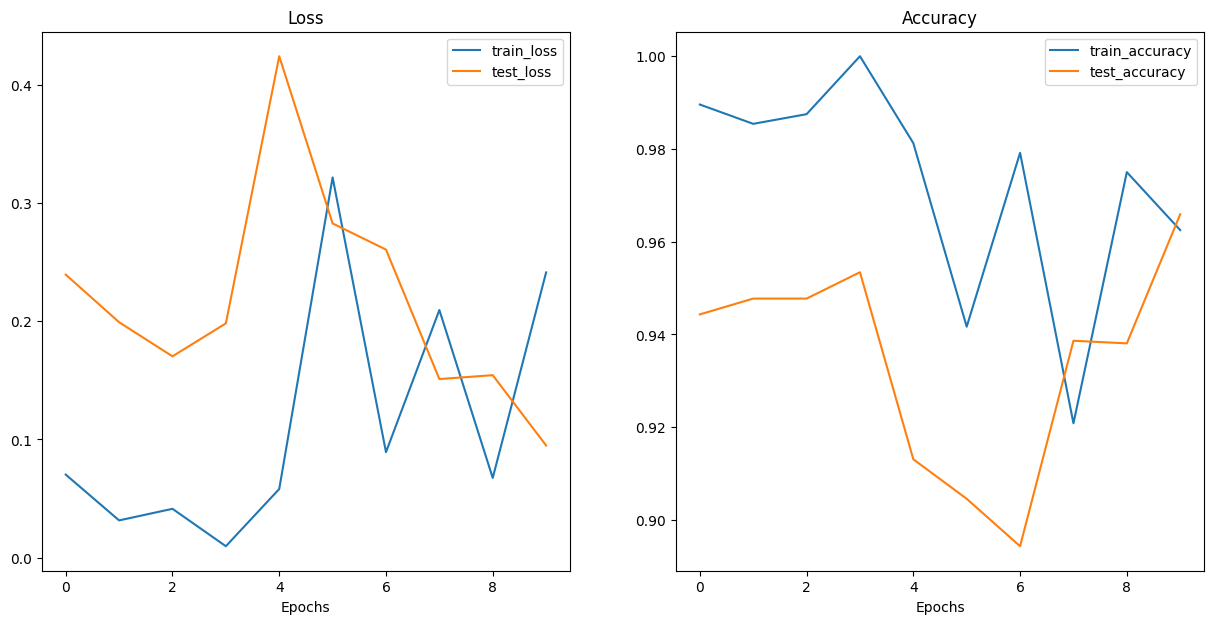

In [51]:
### 3.4 Inspecting Effnetb2 loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)


In [52]:
### 3.5 Saving EffnetB2 feature extractor
from going_modular.going_modular import utils

# Save model
utils.save_model(
    model=effnetb2_model,
    model_name="09_effnetb2_model_feature_extractor_pizza_steak_sushi_20_percent.pth",
    target_dir="models"
)

[INFO] Saving model to: models/09_effnetb2_model_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffnetB2 feature extractor

Why would it be import to consider the siz of a saved model ?

If we are going to deploy on mobile / web site there mabye limited computing resources.



In [53]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/09_effnetb2_model_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"EffnetB2 model size: {pretrained_effnetb2_model_size:.2f} MB")

EffnetB2 model size: 29.86 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [54]:
# Count number of paramaters in EffNetB2
effnetb2_total_params = sum(p.numel() for p in effnetb2_model.parameters())
effnetb2_total_params


7705221

In [55]:
# Create a dictionary with EffNetB2 with Statistics

effnetb2_stats = {
    "test_loss": effnetb2_results["test_loss"][-1],
    "test_acc": effnetb2_results["test_acc"][-1],
    "train_loss": effnetb2_results["train_loss"][-1],
    "train_acc": effnetb2_results["test_acc"][-1],
    "number_of_paramaters": effnetb2_total_params,
    "model_size (MB)": pretrained_effnetb2_model_size
}

effnetb2_stats


{'test_loss': 0.09492655685171485,
 'test_acc': 0.965909090909091,
 'train_loss': 0.24142383423944314,
 'train_acc': 0.965909090909091,
 'number_of_paramaters': 7705221,
 'model_size (MB)': 29.8613224029541}

## 4. Creating a ViT feature extractor

In [47]:
# Checkout the ViT head layer
vit = torchvision.models.vit_b_16(weights="DEFAULT")
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [60]:
def create_vit_model(
    num_classes:int=3,
    seed:int=42
):

  # 1. Setup pretrained model weights
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT

  # 2. Get the ViT base transforms
  transforms = weights.transforms()

  # 3. Load the pretrained model
  model = torchvision.models.vit_b_16(weights=weights)

  # 4. Freeze the base layers in the model (this will stop all layers weight from training)
  for param in model.parameters():
      param.requires_grad = False

  # 5. Change the classifier head with random number for max reproducibility
  set_seeds(seed=seed)
  model.heads = torch.nn.Sequential(
      torch.nn.Linear(in_features=768, out_features=num_classes),
  )


  return model, transforms

In [62]:
vit, vit_transforms = create_vit_model(num_classes=3)
vit, vit_transforms

(VisionTransformer(
   (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
   (encoder): Encoder(
     (dropout): Dropout(p=0.0, inplace=False)
     (layers): Sequential(
       (encoder_layer_0): EncoderBlock(
         (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (self_attention): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
         )
         (dropout): Dropout(p=0.0, inplace=False)
         (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (mlp): MLPBlock(
           (0): Linear(in_features=768, out_features=3072, bias=True)
           (1): GELU(approximate='none')
           (2): Dropout(p=0.0, inplace=False)
           (3): Linear(in_features=3072, out_features=768, bias=True)
           (4): Dropout(p=0.0, inplace=False)
         )
       )
       (encoder_layer_1): EncoderBlock(
         (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine

In [63]:
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create dataloaders for ViT feature extractor

In [64]:

from going_modular.going_modular import data_setup

vit_train_dataloader, vit_test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

len(vit_train_dataloader), len(vit_test_dataloader), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Train a ViT Feature Extractor

In [66]:
from going_modular.going_modular import engine


# Setup optimizer
optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()


# Train ViT feature extractor
set_seeds()

vit_results = engine.train(
    model=vit,
    train_dataloader=vit_train_dataloader,
    test_dataloader=vit_test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Plot loss curves of ViT feature extractor

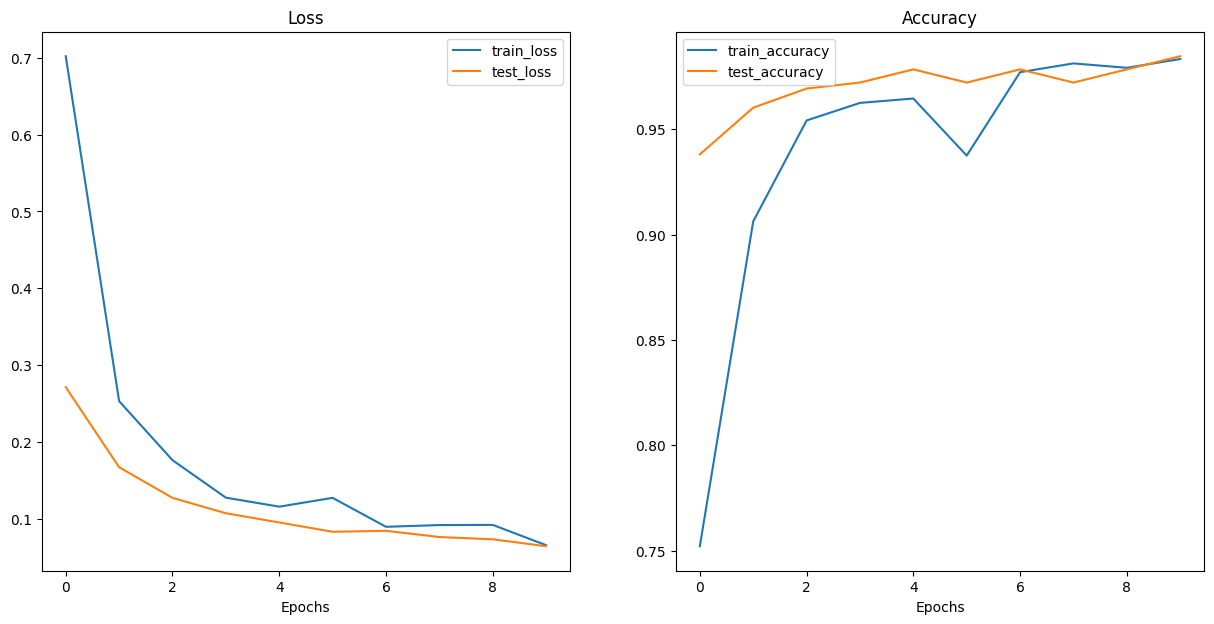

In [68]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)


### 4.4 Save of ViT feature extractor model

In [69]:
from going_modular.going_modular import utils

utils.save_model(
    model=vit,
    target_dir="models",
    model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")


[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [72]:
from pathlib import Path

pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained ViT model size: {pretrained_vit_model_size:.2f} MB")

Pretrained ViT model size: 327.37 MB


In [73]:
vit_total_params = sum(p.numel() for p in vit.parameters())
print(f"Total number of parameters: {vit_total_params}")

Total number of parameters: 85800963


### 4.6 Collecting ViT Feature Extractor Stats

In [75]:
vit_stats = {
    "test_loss": vit_results["test_loss"][-1],
    "test_acc": vit_results["test_acc"][-1],
    "train_loss": vit_results["train_loss"][-1],
    "train_acc": vit_results["test_acc"][-1],
    "number_of_paramaters": vit_total_params,
    "model_size (MB)": pretrained_vit_model_size
}

vit_stats

{'test_loss': 0.06443453514948487,
 'test_acc': 0.984659090909091,
 'train_loss': 0.06576697633912167,
 'train_acc': 0.984659090909091,
 'number_of_paramaters': 85800963,
 'model_size (MB)': 327.37096977233887}

## 5. Making prediction with our trained models and timing